### imports and base setup

In [13]:
from diode import DIODE, plot_depth_map, plot_normal_map
import matplotlib.pyplot as plt
import cv2
import argparse
import numpy as np
import os
import json
import shutil

In [14]:
def generate_dataset_structure(base_path):
    dataset_json = {}

    scene_index = 0

    for scene_dir in sorted(os.listdir(base_path)):
        if not os.path.isdir(os.path.join(base_path, scene_dir)):
            continue

        scene_name = f"scene_{scene_index:05d}"
        dataset_json[scene_name] = {}

        for scan_dir in sorted(os.listdir(os.path.join(base_path, scene_dir))):
            if not os.path.isdir(os.path.join(base_path, scene_dir, scan_dir)):
                continue

            scan_name = f"scan_{scan_dir}"
            dataset_json[scene_name][scan_name] = []

            scan_path = os.path.join(base_path, scene_dir, scan_dir)
            scan_files = sorted(os.listdir(scan_path))

            for filename in scan_files:
                dataset_json[scene_name][scan_name].append(filename)

        scene_index += 1

    return dataset_json


In [15]:
data_root = "../full_dataset"
dataset_structure = generate_dataset_structure(data_root)

meta_fname = "./dataset_structure.json"
with open(meta_fname, "w") as f:
    json.dump(dataset_structure, f, indent=4)

print("Dataset structure JSON has been generated and saved.")

Dataset structure JSON has been generated and saved.


In [16]:
for split in ('train', 'val'):
    for scene_type in ('outdoor', 'indoors'):
        dset = DIODE(
            meta_fname, data_root, splits=split, scene_types=scene_type
        )
        scenes = dset.meta[split][scene_type]
        num_scenes = len(scenes)
        num_scans = sum([ len(v) for k, v in scenes.items() ])
        print('{:8} {:8} {:<2} scenes {} scans {:>5} images'.format(
            split, scene_type, num_scenes, num_scans, len(dset))
        )

indoors scenes 5 scans 5 images 200


In [17]:
dset = DIODE(meta_fname, data_root, splits='val', scene_types='indoors')

In [12]:
im, dm, mask, norm = dset[0]

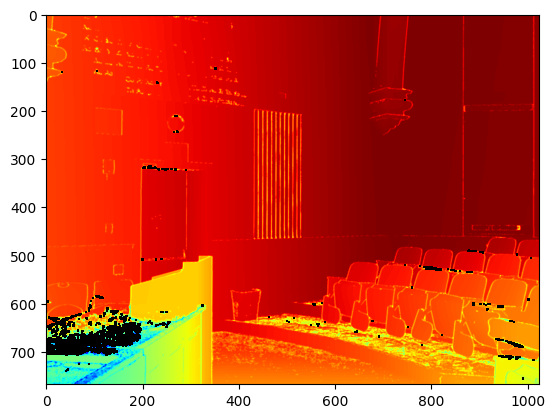

In [9]:
plot_depth_map(dm, mask)

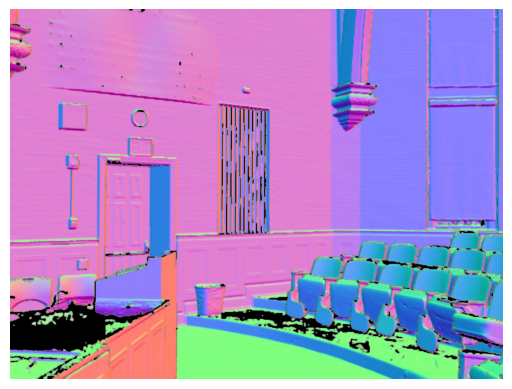

In [10]:
plot_normal_map(norm)

### Compute normals from Marigold depth maps

In [19]:
class DepthToNormalMap:
    """A class for converting a depth map image to a normal map image."""

    def __init__(self, depth_map_path: str, max_depth: int = 255) -> None:
        """Constructs a DepthToNormalMap object.

        Args:
            depth_map_path (str): The path to the depth map image file.
            max_depth (int, optional): The maximum depth value in the depth map image.
                Defaults to 255.

        Raises:
            ValueError: If the depth map image file cannot be read.
        """
        self.depth_map = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED)

        if self.depth_map is None:
            raise ValueError(
                f"Could not read the depth map image file at {depth_map_path}"
            )
        # Normalize the depth map to [0, 1]
        self.depth_map = self.depth_map / (65535 * 255)
        self.max_depth = max_depth
        self.scaling_factor = 255
        self.clicked_points = []

    def circular_filter(self, image, radius):
        """Applies a circular filter of specified radius to the input image."""
        kernel = np.zeros((2*radius + 1, 2*radius + 1))
        y_circle, x_circle = np.ogrid[-radius:radius + 1, -radius:radius + 1]
        circular_mask = x_circle**2 + y_circle**2 <= radius**2
        kernel[circular_mask] = 1
        kernel /= np.sum(kernel)
        return cv2.filter2D(image, -1, kernel)

    def calculate_normals(self, factor) -> None:
        """Calculates normal vectors for the entire image."""
        rows, cols = self.depth_map.shape

        x, y = np.meshgrid(np.arange(cols), np.arange(rows))
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        
        scaled_image = (self.depth_map * self.scaling_factor)
        depth_float32 = scaled_image.astype(np.float32)
        
        if factor == "bilateral":
            depth_float32 = cv2.bilateralFilter(depth_float32, 9, 75, 75) # 9 75 75 best

        if factor == "gauss":
            depth_float32 = cv2.GaussianBlur(depth_float32, (7, 7), 0) # 7 the best

        if factor == "median":
            depth_float32 = cv2.medianBlur(depth_float32, 5) # 5 the best

        if factor == "circular":
            depth_float32 = self.circular_filter(depth_float32, radius=9) # 9 the best 

        if factor == "none":
            pass

        dx = cv2.Scharr(depth_float32, cv2.CV_32F, 1, 0)
        dy = cv2.Scharr(depth_float32, cv2.CV_32F, 0, 1)

        normal = np.dstack((-dx, -dy, np.ones((rows, cols))))
        norm = np.sqrt(np.sum(normal**2, axis=2, keepdims=True))
        normal = np.divide(normal, norm, out=np.zeros_like(normal), where=norm != 0)

        self.normals_map = normal

    def save_normals_map(self, output_path: str) -> None:
        """Saves the computed normals map to a .npy file.

        Args:
            output_path (str): Path to save the .npy file.
        """
        if self.normals_map is not None:
            np.save(output_path, self.normals_map)
        else:
            print("Error: Normals map is not computed yet. Call calculate_normals() first.")

    def save_normal_map(self, output_path: str):
        """Converts the depth map image to a normal map image.

        Args:
            output_path (str): The path to save the normal map image file.
        """
        # i should do these next 2 lines as otherwise the image is black
        normal = (self.normals_map + 1) * 127.5
        normal = normal.clip(0, 255).astype(np.uint8)
        normal_bgr = cv2.cvtColor(normal, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, normal_bgr)

In [23]:
depth_maps_directory = "full_dataset/depth_maps"
output_normals_directory = "full_dataset/normals"
os.makedirs(output_normals_directory, exist_ok=True)

filtering_methods = ["bilateral", "gauss", "median", "circular", "none"]

for filename in os.listdir(depth_maps_directory):
    if filename.endswith(".png"):
        depth_map_path = os.path.join(depth_maps_directory, filename)
        image_name = os.path.splitext(filename)[0]

        if "_depth_16bit" in image_name:
            image_name = image_name.replace("_depth_16bit", "")

        for method in filtering_methods:
            converter = DepthToNormalMap(depth_map_path, max_depth=255)

            converter.calculate_normals(factor=method)
            output_npy_path = os.path.join(output_normals_directory, f"{image_name}_normal_{method}.npy")
            converter.save_normals_map(output_npy_path)

In [26]:
def check_generated_normals(depth_maps_directory: str, output_normals_directory: str, filtering_methods: list):
    """Check if all expected normal maps are generated for each image in the specified directory.

    Args:
        depth_maps_directory (str): Directory containing depth map images.
        output_normals_directory (str): Directory containing generated normal maps.
        filtering_methods (list): List of filtering methods used to generate normal maps.
    """
    for filename in os.listdir(depth_maps_directory):
        if filename.endswith(".png"):
            image_name, _ = os.path.splitext(filename)
            image_name = image_name.replace("_depth_16bit", "")
            missing_normal_methods = []

            for method in filtering_methods:
                normal_file_path = os.path.join(output_normals_directory, f"{image_name}_normal_{method}.npy")
                if not os.path.exists(normal_file_path):
                    missing_normal_methods.append(method)
                    print(missing_normal_methods)

            if missing_normal_methods:
                print(f"Error: Normals missing for {image_name}. Missing methods: {missing_normal_methods}")

depth_maps_directory = "full_dataset/depth_maps"
output_normals_directory = "full_dataset/normals"
filtering_methods = ["bilateral", "gauss", "median", "circular", "none"]
check_generated_normals(depth_maps_directory, output_normals_directory, filtering_methods)

In [27]:
dir1 = "full_dataset/depth_maps"
dir2 = "full_dataset/normals"

files_in_directory1 = os.listdir(dir1)
files_in_directory2 = os.listdir(dir2)

num_files1 = len(files_in_directory1)
num_files2 = len(files_in_directory2)

print(f"Number of files in {depth_maps_directory}: {num_files1}")
print(f"Number of files in {output_normals_directory}: {num_files2}")

Number of files in full_dataset/depth_maps: 1000
Number of files in full_dataset/normals: 200


In [35]:
def move_matching_files(source_folder, destination_folder, names_folder):
    """Move files from source_folder to destination_folder if their names (without filter suffix) are found in names_folder."""
    os.makedirs(destination_folder, exist_ok=True)

    existing_names = set()
    for root, dirs, files in os.walk(names_folder):
        for file in files:
            base_name = file.split("_normal_")[0]
            base_name = base_name + "_normal.npy"
            existing_names.add(base_name)

    # Traverse through each file in source_folder
    result = 0
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if file in existing_names:
                # Construct source and destination paths
                source_path = os.path.join(root, file)
                destination_path = os.path.join(destination_folder, file)
                shutil.move(source_path, destination_path)

In [36]:
source_folder = "full_dataset/val/indoors"
destination_folder = "full_dataset/ground_truth_normals"
names_folder = "full_dataset/normals"
move_matching_files(source_folder, destination_folder, names_folder)

In [37]:
all_names = []

existing_names = set()
for root, dirs, files in os.walk("full_dataset/depth_maps"):
    for file in files:
        base_name = file.split("_depth_")[0]
        all_names.append(base_name)

In [45]:
class Metric(object):
    def __init__(self):

        self.results = {}
        self.filters = []
        self.eval_keys = ['mean_angle', 'median_angle', 'threshold_11_25', 'threshold_22_5', 'threshold_30']

    def update_norm(self, gt, pred, filter_name):
        assert gt.shape == pred.shape

        results = self.calculate_normal_metrics(gt, pred)

        if filter_name not in self.results:
            self.results[filter_name] = {}

        for key, value in zip(self.eval_keys, results):
            if key not in self.results[filter_name]:
                self.results[filter_name][key] = []
            self.results[filter_name][key].append(value)

        if filter_name not in self.filters:
            self.filters.append(filter_name)

    def save_results(self, output_directory):
        os.makedirs(output_directory, exist_ok=True)
        for filter_name in self.filters:
            output_file_path = os.path.join(output_directory, f"{filter_name}_evaluation.txt")
            with open(output_file_path, "w") as f:
                f.write("Evaluation Complete for Filter: {}\n".format(filter_name))
                for key in self.eval_keys:
                    avg_value = np.mean(self.results[filter_name][key])
                    f.write(f"{key}: {avg_value:.4f}\n")

            print(f"Evaluation results for {filter_name} saved to: {output_file_path}")

    def calculate_normal_metrics(self, normals1, normals2):
        normals1_flat = normals1.reshape(-1, 3)
        normals2_flat = normals2.reshape(-1, 3)
        zero_indices_1 = np.where(~np.any(normals1_flat, axis=1))[0]
        valid_indices = np.setdiff1d(np.arange(len(normals1_flat)), zero_indices_1)
        valid_normals1 = normals1_flat[valid_indices]
        valid_normals2 = normals2_flat[valid_indices]
        
        dot_products = np.sum(valid_normals1 * valid_normals2, axis=1)
        dot_products = np.clip(dot_products, -1.0, 1.0)
        angles = np.arccos(dot_products)
        angle_degrees = np.degrees(angles)

        avg = np.mean(np.degrees(angles))
        median = np.median(np.degrees(angles))
        threshold_11_25 = (angle_degrees < 11.25).mean() * 100
        threshold_22_5 = (angle_degrees < 22.5).mean() * 100
        threshold_30 = (angle_degrees < 30).mean() * 100

        return avg, median, threshold_11_25, threshold_22_5, threshold_30


In [46]:
metric = Metric()

In [48]:
gt_normals = "full_dataset/ground_truth_normals"
pred_normals = "full_dataset/normals"
filter_names = ["bilateral", "gauss", "median", "circular", "none"]
output_directory = "evaluation_results"

for filter in filter_names:
    for name in all_names:
        gt_path = f"{gt_normals}/{name}_normal.npy"
        pred_path = f"{pred_normals}/{name}_normal_{filter}.npy"
        
        gt_normal = np.load(gt_path)
        pred_normal = np.load(pred_path)
        metric.update_norm(gt_normal, pred_normal, filter)

metric.save_results(output_directory)

Evaluation results for bilateral saved to: evaluation_results/bilateral_evaluation.txt
Evaluation results for gauss saved to: evaluation_results/gauss_evaluation.txt
Evaluation results for median saved to: evaluation_results/median_evaluation.txt
Evaluation results for circular saved to: evaluation_results/circular_evaluation.txt
Evaluation results for none saved to: evaluation_results/none_evaluation.txt
